In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.9.2
Numpy version:  1.21.6
Pandas version:  1.3.5
Scikit-learn version:  1.0.2


In [ ]:
file = np.load('/content/drive/MyDrive/Colab Notebooks/CWU Optimization/cwru_archive/CWRU_48k_load_1_CNN_wavelet_morlet_data.npz')
print(file.files)

['data', 'labels']


In [ ]:
data = file['data']
labels = file['labels']
print(data.shape, labels.shape)

(4600, 32, 32) (4600,)


In [ ]:
print(data[0])
print(labels)

[[ 0.06489466  0.06258056  0.11481723 ...  0.11298084 -0.07618546
  -0.00962577]
 [ 0.01695936 -0.26479104  0.23692891 ... -0.01805164 -0.23221928
   0.17369527]
 [-0.09308606 -0.07591055  0.04793139 ...  0.1505585   0.0248714
  -0.0505239 ]
 ...
 [ 0.10248408 -0.27096152 -0.30217856 ... -0.04066667  0.27857864
   0.48639479]
 [ 0.13174711  0.10673141  0.03245776 ...  0.13669541  0.0687592
   0.06441689]
 [-0.00760916 -0.1538495  -0.30417514 ... -0.22986597 -0.20058736
  -0.12898165]]
['Ball_007' 'Ball_007' 'Ball_007' ... 'Normal' 'Normal' 'Normal']


In [ ]:
category_labels = np.unique(labels)
print(category_labels)

['Ball_007' 'Ball_014' 'Ball_021' 'IR_007' 'IR_014' 'IR_021' 'Normal'
 'OR_007' 'OR_014' 'OR_021']


In [ ]:
labels = pd.Categorical(labels, categories = category_labels).codes

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 1000, random_state = 829, stratify = labels)

In [ ]:
# Reshape data as input should be three dimensional to a CNN

train_data = train_data.reshape(len(train_data),32,32,1)
test_data = test_data.reshape(len(test_data),32,32,1)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Shuffle data
index = np.random.permutation(len(train_labels))
trian_data, trian_labels = train_data[index], train_labels[index]

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape )

(3600, 32, 32, 1) (3600, 10) (1000, 32, 32, 1) (1000, 10)


In [ ]:
demo_model = Sequential([
    layers.Conv2D(32,3,activation= 'relu', input_shape = (32,32,1)),
    layers.MaxPool2D(2),
    layers.Conv2D(32,5,activation = 'relu'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(128,activation = 'relu'),
    layers.Dense(96, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
])
demo_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 32)        25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [ ]:
def create_compiled_model():
    model = Sequential([
    layers.Conv2D(32,3,activation= 'relu', input_shape = (32,32,1)),
    layers.MaxPool2D(2),
    layers.Conv2D(32,5,activation = 'relu'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(128,activation = 'relu'),
    layers.Dense(96, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
    ])
    model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001), 
                  metrics= ['accuracy'])
    return model

In [ ]:
res = np.empty(10)
res[:] = np.nan
for i in range(10):
    model = create_compiled_model()
    history = model.fit(train_data, train_labels, epochs = 35, batch_size = 128, verbose = 0)    # Verbosity is set to zero
    res[i] = model.evaluate(test_data, test_labels, batch_size = 128, verbose = 0)[1]            # Verbosity is set to zero
    print('Loop iteration %d, Accuracy: %4.4f' % (i+1, res[i]))
    if res[i]>=np.max(res[:(i+1)]):
        best_model = model

Loop iteration 1, Accuracy: 0.9890
Loop iteration 2, Accuracy: 0.9910
Loop iteration 3, Accuracy: 0.9920
Loop iteration 4, Accuracy: 0.9890
Loop iteration 5, Accuracy: 0.9920
Loop iteration 6, Accuracy: 0.9910
Loop iteration 7, Accuracy: 0.9830
Loop iteration 8, Accuracy: 0.9940
Loop iteration 9, Accuracy: 0.9920
Loop iteration 10, Accuracy: 0.9910


In [ ]:
print('Average accuracy:%4.4f'%(np.mean(res))) # After running the model 10 times
print("Best accuracy: %4.4f"%(np.max(res)))
print("Worst accuracy: %4.4f"%(np.min(res)))
print('Standard deviation: %4.4f' % (np.std(res)))

Average accuracy:0.9904
Best accuracy: 0.9940
Worst accuracy: 0.9830
Standard deviation: 0.0028


In [ ]:
tf.keras.models.save_model(best_model, "/content/drive/MyDrive/Colab Notebooks/CWU Optimization/CWRU_CNN_continuous_wavelet_transform.h5")

In [ ]:
prediction = best_model.predict(test_data)
prediction_labels = list([])
for each_prediction in prediction:
    prediction_labels.append(list(each_prediction).index(max(each_prediction)))

32/32 [==============================] - 1s 14ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
true_labels = np.argmax(test_labels, axis = 1)
matrix = confusion_matrix(true_labels, prediction_labels)

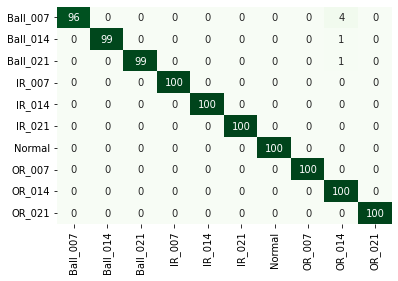

In [ ]:
import seaborn as sns
matrix = pd.DataFrame(matrix)
plt.figure()
sns.heatmap(matrix, annot= True, fmt = "d",
           xticklabels = category_labels,
           yticklabels = category_labels, cmap = "Greens", cbar = False)
plt.xticks(rotation = 90)
plt.show()